In [1]:
# For NumCosmo
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from scipy.stats import chi2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import numpy as np
import math
# The corner package is needed to view the results of the MCMC analysis
import corner



In [2]:
os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [3]:
nwalkers = 320
burnin   = 5000

mcat  = Ncm.MSetCatalog.new_from_file_ro ("../examples/example_rosenbrock_aps_st_320.fits",     nwalkers * burnin)
mcat2 = Ncm.MSetCatalog.new_from_file_ro ("../examples/example_rosenbrock_stretch_st_320.fits", nwalkers * burnin)


In [4]:
s1d1 = chi2.cdf (1.0, df = 1)
s1d2 = chi2.cdf (4.0, df = 1)
s2d1 = chi2.cdf (1.0, df = 1)
s2d2 = chi2.cdf (4.0, df = 1)
s2d3 = chi2.cdf (9.0, df = 1)
qts = [0.5 - s1d2 / 2.0, 0.5 - s1d1 / 2.0, 0.5, 0.5 + s1d1 / 2.0, 0.5 + s1d2 / 2.0]

print (qts)
print (s2d1, s2d2, s2d3)


[0.022750131948179264, 0.15865525393145707, 0.5, 0.84134474606854293, 0.97724986805182068]
0.682689492137 0.954499736104 0.997300203937


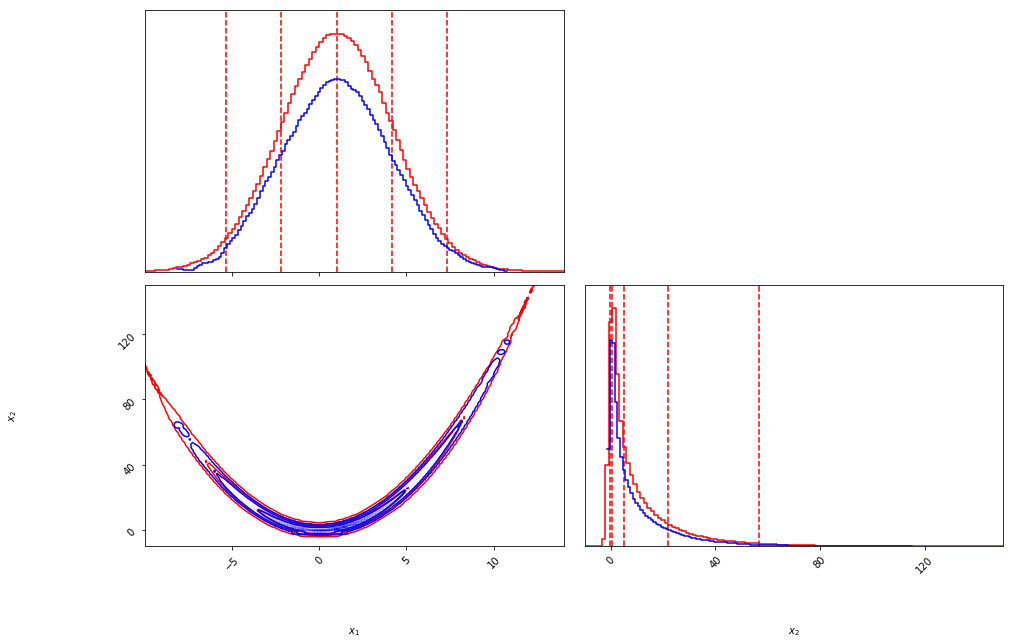

In [5]:
rows = np.array ([mcat.peek_row (i).dup_array () for i in range (0, mcat.len ())])
params = ["$" + mcat.col_symb (i) + "$" for i in range (mcat.ncols ())]
figure = corner.corner (rows[:,1:], labels = params[1:], reverse = False,
                        quantiles=qts, levels = (s2d1, s2d2, s2d3), 
                        bins = 120, smooth = 0.8, smooth1d = 0.8, color = "red",
                        range = [(-10, 14), (-10, 150)])

rows2 = np.array ([mcat2.peek_row (i).dup_array () for i in range (0, mcat2.len ())])
params = ["$" + mcat2.col_symb (i) + "$" for i in range (mcat2.ncols ())]
figure = corner.corner (rows2[:,1:], labels = params[1:], reverse = False,
                        levels = (s2d1, s2d2, s2d3), color = "blue",
                        bins = 120, smooth = 0.8, smooth1d = 0.8, fig = figure)

figure.set_size_inches(16, 10)


OSError: [Errno 12] Cannot allocate memory

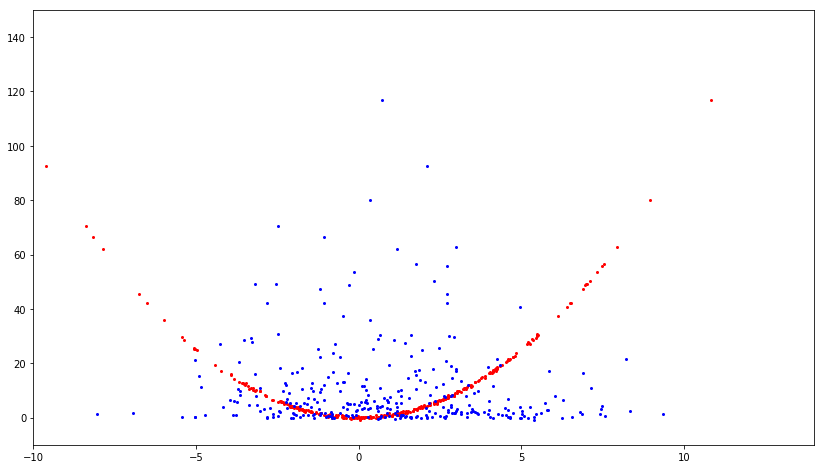

In [6]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.set(xlim=(-10, 14), ylim=(-10, 150))

scat = ax.scatter(rows[0:nwalkers,1], rows[0:nwalkers,2], s = 4, c = "red")
scat2 = ax.scatter(rows2[0:nwalkers,1], rows[0:nwalkers,2], s = 4, c = "blue")

nframes = 600
b = np.unique (np.floor (np.linspace (0, rows.shape[0]/nwalkers, nframes)).astype(int))
nframes = len (b)

def animate(i):    
    x_i = rows[nwalkers * b[i] : nwalkers * b[i + 1], 1]
    y_i = rows[nwalkers * b[i] : nwalkers * b[i + 1], 2]
    x2_i = rows2[nwalkers * b[i] : nwalkers * b[i + 1], 1]
    y2_i = rows2[nwalkers * b[i] : nwalkers * b[i + 1], 2]
    scat.set_offsets(np.c_[x_i, y_i])
    scat2.set_offsets(np.c_[x2_i, y2_i])

anim = FuncAnimation (fig, animate, interval=50, frames=nframes-1)
 
#plt.draw()
#plt.show()

HTML (anim.to_html5_video ())

In [7]:
n = min (int(rows.shape[0]/nwalkers), int(rows2.shape[0]/nwalkers))
sv = Ncm.StatsVec.new (1, Ncm.StatsVecType.VAR, False)

tevar = []
tevar_var = []
for i in range (n-1):
    for w in range (nwalkers):
        sv.set (0, rows[i*nwalkers + w, 2])
        sv.update_weight (1.0)
    tevar.append (sv.get_mean (0))


    
    
sv.reset (True)
    
tevar2 = []
tevar_var2 = []
for i in range (n-1):
    for w in range (nwalkers):
        sv.set (0, rows2[i*nwalkers + w, 2])
        sv.update_weight (1.0)
    tevar2.append (sv.get_mean (0))

for i in range (0,20000):
    tevar_var.append(mcat.peek_e_var_t(i).dup_array()[0])
    tevar_var2.append(mcat2.peek_e_var_t(i).dup_array()[0])
    
tevar_var_mean = [np.mean(tevar_var[0:(i+1)]) for i in range(len(tevar_var)-1)]

tevar_var_mean2 = [np.mean(tevar_var2[0:(i+1)]) for i in range(len(tevar_var2)-1)]

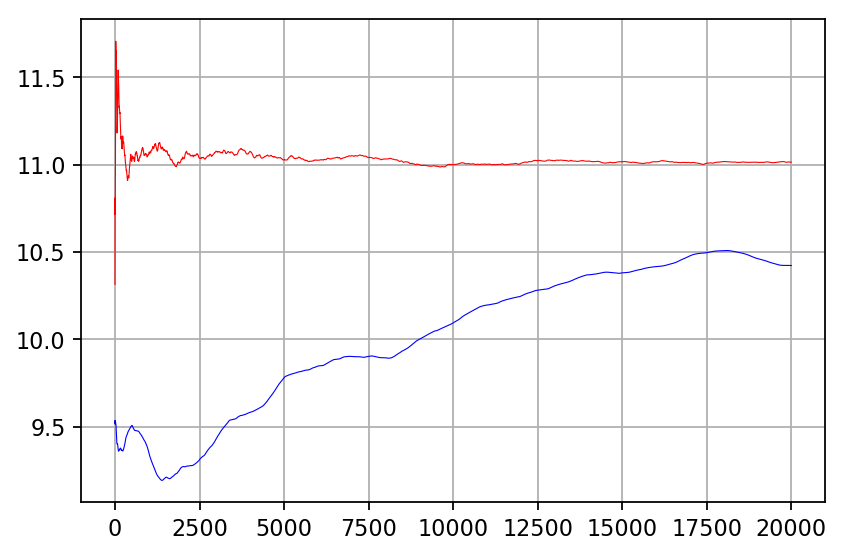

In [8]:
plt.figure (dpi = 160)
plt.plot (tevar,  c = 'red',  lw = 0.5)
plt.plot (tevar2, c = 'blue', lw = 0.5)
plt.grid ()
#plt.ylim (3.8, 4.2)

IndexError: list index out of range

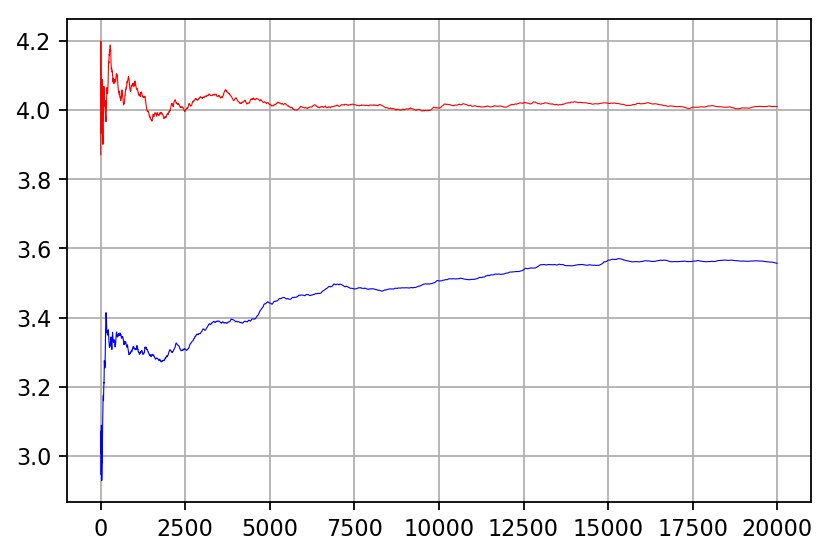

In [9]:
plt.figure (dpi = 160)

plt.plot (tevar_var_mean,  c = 'red',  lw = 0.5)
plt.plot (tevar_var_mean2, c = 'blue', lw = 0.5)
plt.grid ()
#plt.ylim (3.8, 4.2)


In [11]:
print(tevar_var_mean[-1], tevar_var_mean2[-1])

4.01090869497 3.55712748583
